\newpage

# 0 Setup {-}

In [34]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [35]:
# importing tensorflow
try:
    import google.colab
    import tensorflow as tf
    %tensorflow_version 1.13
except:
    import tensorflow as tf
    assert tf.__version__ == "1.13.1"
    
    # ignore tensorflow depreciation warnings
    import tensorflow.python.util.deprecation as deprecation
    deprecation._PRINT_DEPRECATION_WARNINGS = False

In [36]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.factorization import KMeans

\newpage

## 0.1 Helper Functions {-}

In [37]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

    Args:
        input_tensor: The tensor to reduce. Should have numeric type.
        reduction_indices: The dimensions to reduce. 
        keep_dims: If true, retains reduced dimensions with length 1.
    Returns:
        The reduced tensor.
    """
    max_input_tensor1 = tf.reduce_max(input_tensor, reduction_indices, keep_dims=keep_dims)
    max_input_tensor2 = max_input_tensor1
    if not keep_dims:
        max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
    return tf.log(
            tf.reduce_sum(
              tf.exp(input_tensor - max_input_tensor2),
              reduction_indices,
              keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
    """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

    Args:
        input_tensor: Unnormalized log probability.
    Returns:
        normalized log probability.
    """
    return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

\newpage

## 0.2 Plotting Functions {-}

In [124]:
def plot_loss(train_loss, valid_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    
    x = np.arange(0, len(train_loss), 1)
    ax.plot(x, train_loss, label="Training Loss")
    if not valid_loss is None:
        ax.plot(x, valid_loss, label="Valdation Loss")
    
    ax.set_title("Loss" if title == None else title)
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")
    
    
def plot_cluster(K, MU, S, title=None, ax=None, save=False):
    ax = plt.gca() if ax == None else ax
    
    colours = ['turquoise', 'lightseagreen', 'aquamarine', 'paleturquoise', 'mediumaquamarine']
    for i in range(K):
        x, y = S[i][:,0], S[i][:,1]
        ax.scatter(x, y, c=colours[i], alpha=0.5, label=str(i+1))
        ax.scatter(MU[i][0], MU[i][1], c='black', marker='x', s=50)
    
    ax.set_title(f"{K}-Means Clustering" if title == None else title)
    ax.legend(fontsize="small")
   
    if save:
        plt.savefig(f"{K}Means_cluster.png", dpi=300)
        plt.show()

def plot(K, MU, S_train, train_loss, S_valid=None, valid_loss=None):
    
    if S_valid is None or valid_loss is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        plot_loss(train_loss, valid_loss, title=f"Loss for {K}-Means Clustering", ax=ax[0])
        plot_cluster(K, MU, S_train, title=f"{K}-Means Clustering", ax=ax[1])
    else:
        fig, ax = plt.subplots(1, 3, figsize=(15, 4))
        plot_loss(train_loss, valid_loss, title=f"Loss for {K}-Means Clustering", ax=ax[0])
        plot_cluster(K, MU, S_train, title=f"{K}-Means Clustering - Training Data", ax=ax[1])
        plot_cluster(K, MU, S_valid, title=f"{K}-Means Clustering - Validation Data", ax=ax[2])
    
    plt.show()
    plt.close()

## 0.3 Data Loaders {-}

In [39]:
def load_2D(valid=True):
    data = np.load('data2D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(69)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data
    
def load_100D(valid=True):
    data = np.load('data100D.npy')
    [num_pts, dim] = data.shape
    
    # getting validation set
    if valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(69)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        train_data = data[rnd_idx[valid_batch:]]
        return train_data, val_data
    else:
        return data

\newpage

# 1 K-means {-}

## 1.1.1 Learning K-means {-}

In [61]:
# Distance function for K-means
def distanceFunc_Kmeans(X, MU):
    """
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    """
    # expand dimensions to properly subract the two
    X_expanded = tf.expand_dims(X, 1)
    MU_expanded = tf.expand_dims(MU, 0)
    
    # uses broadcasting to do the subtraction
    distances = tf.reduce_sum(tf.square(tf.subtract(X_expanded, MU_expanded)), axis=2)
    
    return distances

In [110]:
# loss function
def L(X, MU):
    # calculate pairwise distances
    distances = distanceFunc_Kmeans(X, MU)
    # assign clusters to min val and sum
    return tf.reduce_sum(tf.reduce_min(distances, axis=1))

# tensorflow training loop
def load(K, dims):
    N, D = dims
    X = tf.placeholder(tf.float64)

    with tf.variable_scope("Part1", reuse=tf.AUTO_REUSE):
        # init with random MU
        MU = tf.Variable( np.random.normal(0, 1, (K, D)) )
        
        # loss function
        loss = L(X, MU)

        # set up Adam optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)
    
    return optimizer, loss, X, MU


def Kmeans(K, train_data, valid_data=None, epochs=10):
    train_loss = []
    valid_loss = []

    # load model
    optimizer, loss, X, MU = load(K, train_data.shape)

    # train
    with tf.Session() as sess:
        # init all variables (needed for Adam)
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            # print("Epoch {}".format(epoch+1))

            # run through optimizer and update loss values
            sess.run(optimizer, feed_dict={X: train_data})
            train_loss.append(sess.run(loss, feed_dict={X: train_data}))

            if not valid_data is None:
                valid_loss.append(sess.run(loss, feed_dict={X: valid_data}))
        
        # get final MUs
        feed_dict = {X: train_data}
        MU_optim = sess.run(MU, feed_dict=feed_dict)
    
    train_loss = np.array(train_loss) / train_data.shape[0]       # normalizing loss
    statistics = (train_loss, )
    if not valid_data is None:
        valid_loss = np.array(valid_loss) / valid_data.shape[0]   # normalizing loss
        statistics += (valid_loss, )
    out = (MU_optim, *statistics)
    
    return out

\newpage

In [63]:
def get_clusters(K, MU, X):
    
    # getting square distances
    distances = None
    with tf.Session() as sess:
        distances = sess.run(distanceFunc_Kmeans(X, MU))
        
    S_indices = np.argmin(distances, axis=1)
    
    # getting list of actual clusters
    S = [None]*K
    for i in range(K):
        S[i] = X[S_indices == i] 
    
    return S

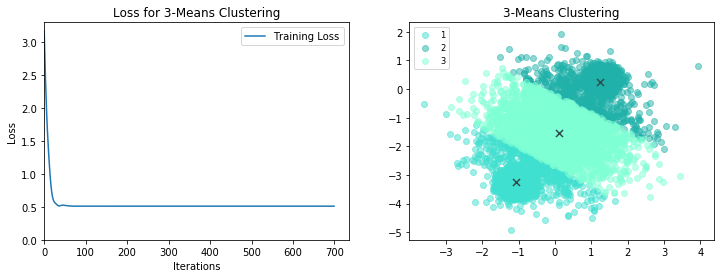

In [99]:
K = 3

# getting data
train_data = load_2D(valid=False)

# compute centroids
MU, train_loss = Kmeans(K, train_data, epochs=700)

# getting clusters
S = get_clusters(K, MU, train_data)

# plot
plot(K, MU, S, train_loss)

\newpage

## 1.1.2 Varying K and 1.1.3 Validation {-}



					Training		Validation
		cluster 1:		 100.00%  		  100.00%


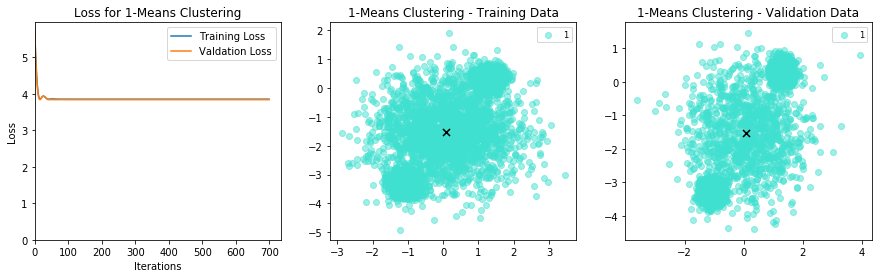



					Training		Validation
		cluster 1:		 50.83%  		  49.68%
		cluster 2:		 49.17%  		  50.32%


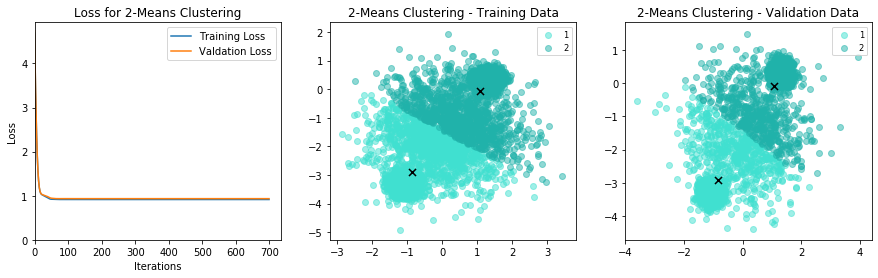



					Training		Validation
		cluster 1:		 38.41%  		  37.62%
		cluster 2:		 37.80%  		  38.46%
		cluster 3:		 23.79%  		  23.91%


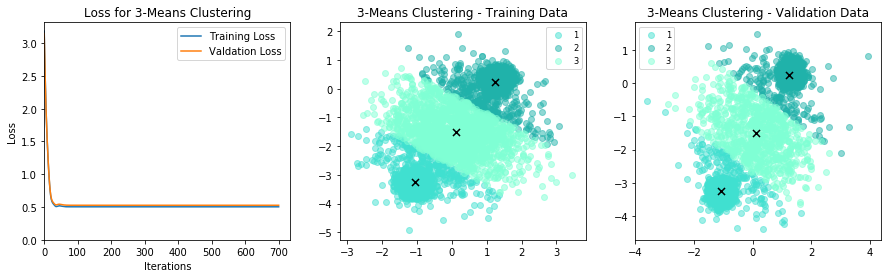



					Training		Validation
		cluster 1:		 12.76%  		  14.07%
		cluster 2:		 37.53%  		  36.27%
		cluster 3:		 37.18%  		  37.44%
		cluster 4:		 12.52%  		  12.21%


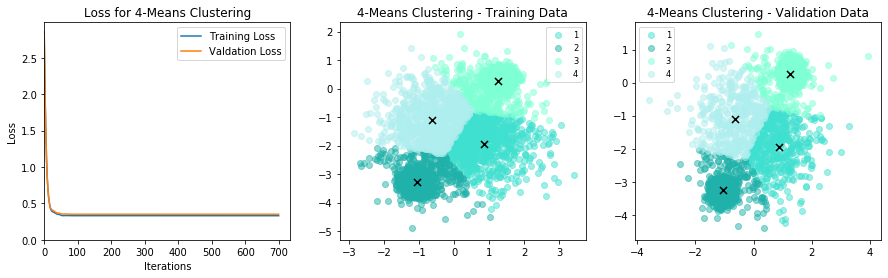



					Training		Validation
		cluster 1:		 36.48%  		  35.34%
		cluster 2:		 36.40%  		  36.75%
		cluster 3:		 8.38%  		  9.21%
		cluster 4:		 8.70%  		  8.91%
		cluster 5:		 10.03%  		  9.78%


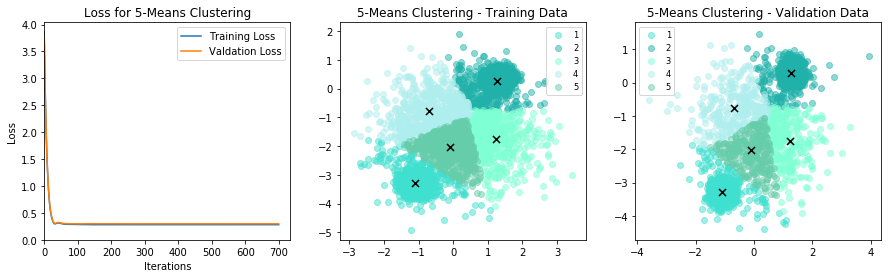

In [126]:
# getting data
train_data, valid_data = load_2D(valid=True)

# define percentages function
def cluster_percentages(K, S):
    """
    Calculates percentage of points that belong to each custer
    """
    total = 0.0
    percentages = np.zeros(K)
    for i in range(K):
        total += S[i].shape[0]
        percentages[i] += S[i].shape[0]
    
    return percentages / total


# Iterate through values of K
for K in [1, 2, 3, 4, 5]:
    
    # compute centroids
    MU, train_loss, valid_loss = Kmeans(K, train_data, valid_data, epochs=700)
    
    # getting clusters
    S_train = get_clusters(K, MU, train_data)
    S_valid = get_clusters(K, MU, valid_data)
    
    # computer percentages
    train_percentages = cluster_percentages(K, S_train)
    valid_percentages = cluster_percentages(K, S_valid)
    print("\n")
    print("\t\t\t\t\tTraining\t\tValidation")
    for i in range(K):
        print(f"\t\tcluster {i+1}:\t\t {train_percentages[i]:.2%}  \t\t  {valid_percentages[i]:.2%}")
    
    # plot
    plot(K, MU, S_train, train_loss, S_valid, valid_loss)

#### Discussion
3 clusters seems to be the best number of clusters. For K $\geq$ 3, the same 2 clusters always apear: the one on the top right and the one in the bottom left. Increasing K only partitions the big middle cluster.

\newpage

# 2 Mixtures of Gaussians {-}

## 2.1 The Guassian Cluster Model {-}

In [10]:
# Distance function for GMM
def distanceFunc_GM(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    
    """
    NOT SURE IF THIS IS CORRECT
    
    I am fairly certain that what they want is something i wrote into the log_GaussPDF function.
    I have no idea why they even included this in the helper file for gmm, it should just be log_Gauss -Devansh
    """
    
    pair_dist = []
    for x in X:
        row = []
        for mu in MU:
            row.append( np.square(x - mu).sum() )
        pair_dist.append( row )
    
    # only difference is that I square root here
    
    # sorry bro, I think this is wrong -Devansh
    return np.sqrt(pair_dist)

def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    K, N, D = len(mu), len(X), len(X[0])

    pair_dist = []
    for x in X:
        row = []
        for k, mu_k in enumerate(mu):
            # Note that (x-mu).T @ sigma[k]*{dxd identity matrix} @ (x-mu) = 1/sigma[k] * ||x-mu||
            # since sigma[k] is a constant

            # Note that the determinant of a constant times an nxn Identity matrix is the constant raised to n
            # because determinant is linear in each column and the determinant of the identity matrix is 1
            prob = np.exp(-0.5 * np.square(x - mu_k).sum() / sigma[k]) / np.sqrt((2 * np.pi) ** K * sigma[k] ** D)
            row.append(np.log(prob))
        pair_dist.append(row)

    # So, the output here is an NxK matrix. The i,j entry represent the log probability of the the i-th example
    # belonging to cluster j.
    return np.array(pair_dist)

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # So this essentially just normalizes each row of the log_PDF so that each row is a valid probability distribution
    # idk how tensor stuff works, so I'm going to leave you with a breakdown of what this fcn needs to do Sandra
    
    # The input log_PDF is an NxK matrix. Each entry needs to have a term subtracted from it. the update is as follows
    # log_PDF[i][j] = log_PDF[i][j] - log_sumOfExponentialsOfAllEntriesInRowi
    
    # that's literally it
    # Fortunately, the helper function called reduce_logsumexp calculates exactly this.
    
    # reduce_logsumexp should take in the log_PDF matrix (in the form of a tf tensor) and it will output a tensor
    # of dimension Nx1. Please do some vector magic and subtract the i-th entry of this tensor from every
    # entry in the i-th row of log_PDF
    # Thanks!
    return log_PDF

In [11]:
train_data, val_data = load_2D()

N, D = train_data.shape
K = 3

MU = np.random.random_sample((K, D))
pair_dist = distanceFunc_Kmeans(train_data, MU)
print(pair_dist.shape)

(6667, 3)


## 2.2 Learning the MoG {-}

In [12]:
def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    # TODO
    """
    See above cell for 2.1
    """

def log_posterior(log_PDF):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # TODO
    """
    See above cell for 2.1
    """
    
def neg_log_likelihood_gmm(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_likelihood: scalar

    """
    Not sure if this can be vectorized if need for speed
    """
    neg_log_likelihood = 0
    for n, sample in enumerate(log_PDF):
        prob = 0
        for k, clusters in enumerate(sample):
            prob += np.exp(log_pi[k] + log_PDF[n][k])
        neg_log_likelihood -= np.log(prob)
    
    return neg_log_likelihood

# Hello Sandra <3
This section requires us to use tensorflow to use gradient descent to minimize the output of the neg_log_likelihood_gmm function. Can you please do that thanks very much.

Notes:

- The parameters we can change through gradient descent are the entries of matrix MU (NxK), vector sigma (Kx1), and vector pi (Kx1)
- each entry of the sigma vector have a constraint that  they must be non-negative (i.e. $\forall k, \sigma_k \in [0,\infty)$)
    - suggestion from the handout to deal with this: replace $sigma^2$ with exp($\phi$) in the math and the software where $\phi$ is an unconstrained parameter
- the entries of the pi vector must sum up to one (since it is a probability distribution) (i.e. $\sum_{k}\pi_k = 1$)
    - suggestion from the handout to deal with this: replace this constraint with an unconstrained parameter $\psi$ through softmax function $\pi_k = \frac{exp(\psi_k)}{\sum_{k'}exp(\psi_{k'})}$. A log-softmax function is provided in the helper functions file

Rest of the assignment is just tensorflow make model and train

With love, Devansh